---
title: "The impact of COVID-19 restriction on start-up grant application"
author: "Babak Fi Foo"
toc: true
number-sections: true
execute:
  cache: true
---

In [12]:
import warnings
import sys
sys.path.append("../src/")
sys.path.append("../")

from datetime import datetime as dt

# local modules:
import apiConfig
import statTools

import numpy as np

# Data visualization modules:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import PolyCollection

# Statistics Modules:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Reporting Modules:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

plt.rcParams["font.family"] = "Roboto"
warnings.filterwarnings("ignore")


In [13]:
# FIXED PARAMETERS:
COVID_start = dt.strptime("2020-04-01", "%Y-%m-%d")
COVID_end = dt.strptime("2022-02-01", "%Y-%m-%d")
FIGSIZE = (10, 5)
LAGS = 24
COLOR_PALLET = {
    "c1":"#cb997e",
    "c2":"#6b705c",
    "shade":"#ffe8d6"
}

COLOR_PALLET_GRADIENT = "#cb997e", "#ddbea9", "#ffe8d6", "#b7b7a4", "#a5a58d", "#6b705c"

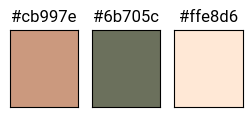

In [14]:

fig, axes = plt.subplots(1,len(COLOR_PALLET.keys()), figsize=(len(COLOR_PALLET.keys()),1))

[ax.get_xaxis().set_visible(False) for ax in axes]
[ax.get_yaxis().set_visible(False) for ax in axes]
for i,k in enumerate(COLOR_PALLET.keys()):
    axes[i].set_facecolor(COLOR_PALLET[k])
    axes[i].set_title(COLOR_PALLET[k])

In [15]:
# Local functions used in the notebook:
def apply_TSplot_theme(axes: list) -> None:
    """Applying same theme on ACF and PACF plots.

    Args:
        axes (list): List of matplotlib Axes objects.
    """
    for ax in axes:
        ax.grid(True, which="both", ls="--", lw=0.5)
        ax.set_ylim(-1.2, 1.2)
        ax.set_xticks(range(0, 26, 2))
        for line in ax.lines:
            line.set_color("none")
            line.set_markerfacecolor(COLOR_PALLET["c1"])
            line.set_markersize(5)
            line.set_markeredgecolor("white")
            
        for item in ax.collections:
            if type(item) == PolyCollection:
                item.set_facecolor(COLOR_PALLET["shade"])
            else:
                item.set_color(COLOR_PALLET["c2"])


def plot_Q_stats(arr, ax, label="ACF", nlags=24):
    Q_stat = acf(arr, qstat=True, nlags=nlags)
    Q_stat = Q_stat[2]  # type: ignore
    ax.plot(
        np.arange(1, 25), Q_stat, linestyle="--", marker="o",
        label = label
    )
    ax.grid(True, which="both", ls="--", lw=0.5)
    ax.set_ylim(0, 1.1)
    ax.set_xticks(range(0, 26, 2))


def plot_CDF_vs_normal(arr, ax):
    mu = np.mean(arr)
    sigma = np.std(arr)
    normal_sample = np.random.normal(mu, sigma, len(arr))
    sns.kdeplot(
        arr,
        cumulative=True,
        label="Residual CDF",
        ax=ax,
        color=COLOR_PALLET["c2"],
        alpha=0.5,
        fill=True,
    )

    sns.kdeplot(
        normal_sample,
        cumulative=True,
        label="Normal CDF",
        ax=ax,
        color="#222222",
    )

    ax.legend(loc="upper left")
    ax.grid(True, which="both", ls="--", lw=0.5)
    ax.set_title("Residual normality")

In [16]:
# Setting up dataset:
startupGrants = apiConfig.startupGrants
startupGrants.load()

grant_data = startupGrants.cleaned_data
labels: dict = startupGrants.labels

Loading Startup Grant Applications data ...
The data file exists
Startup Grant Applications Data loaded.



# Testing for unit root


Before performing any time-series analysis, we must investigate the properties of the data.
Hereafter, we refer to time-series data as a series. The duration of interest is quite close to the COVID time where there is an increase in the number of startup grant applications. 


We specify the COVID restriction period from April 2020 to February 2022.


Investigating this period has the potential to incorrectly identify the series as a stationary trend. Therefore, the entire duration of the data was used for this test to avoid any potential bias.


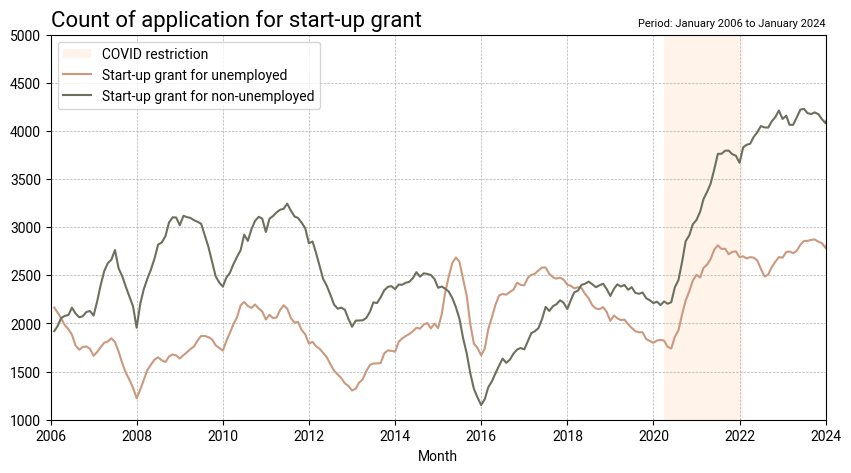

In [17]:
fig = plt.figure(figsize=FIGSIZE)
plt.grid(True, which="both", ls="--", lw=0.5)

plt.xlim(dt.strptime("2006-01-01", "%Y-%m-%d"), dt.strptime("2024-01-01", "%Y-%m-%d"))
plt.ylim(1000, 5000)
ax = plt.gca()

plt.fill_between(
    x=[COVID_start, COVID_end], # type: ignore
    y1=0,
    y2=8000,
    facecolor=COLOR_PALLET["shade"],
    alpha=0.5,
    label="COVID restriction",
)
sns.lineplot(
    data=grant_data.loc[:, ["grantUnemp", "grantEmp"]].rename(columns=labels),
    palette=[COLOR_PALLET["c1"], COLOR_PALLET["c2"]],
    dashes=False,
    ax=ax,
)
legend = ax.legend(loc="upper left")
legend.set_title("")

plt.title("Count of application for start-up grant", fontsize=16, loc="left")
plt.title("Period: January 2006 to January 2024", fontsize=8, loc="right")
plt.show()

A visual inspection of the plot indicates that the series is not stationary. However, the type of nonstationarity requires further investigation.


The DF-GLS test for unit root shows that both series are affected by unit root at their 7th lag and cannot reject the existence of the unit root. Hence, a proper alteration should be applied to make the series stationary. 


In [18]:
col1 = "grantUnemp"
col2 = "grantEmp"
test_df = grant_data.loc[:, [col1,col2]].rename(columns=labels)
unitroot_test = statTools.DFGLSTest(data=test_df)
unitroot_test.summary()

                                  Test Statistic P-value Lags
variable                                                     
Start-up grant for unemployed             -2.520   0.112    1
Start-up grant for non-unemployed         -1.157   0.767   13

Trend: Constant
Critical Values: -2.66 (1%), -2.04 (5%), -1.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.



First, differencing the series results in a stationary series. This implies that the unit root is not caused by a trend or drift. Hence, the plausable data-generating process is:


$$
	y_{t} = \alpha_0 + \alpha_1 y_{t-1} + \varepsilon_{t}
$$




where $y_{t}$ is the series, $\alpha_0$ and $\alpha_1$ are unknown coefficients, and $\varepsilon_{t}$ is a white-noise disturbance. Coefficient $\alpha_1$ is assumed to be equal to $1$ because of the unit-root properties of the series. First, differencing the series should make it stationary.


$$ y_{t} - y_{t-1} = \Delta y_t=\alpha_0 + y_{t-1} - y_{t-1} + \varepsilon_{t} =  \alpha_0 + \varepsilon_{t} $$




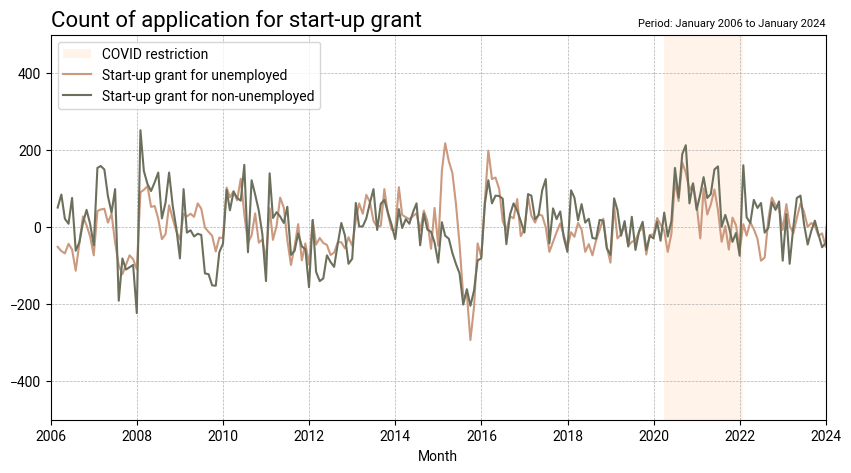

In [19]:
plot_df = (
    grant_data.loc[:, ["grantUnemp", "grantEmp"]].diff().rename(columns=labels).copy()
)

fig = plt.figure(figsize=FIGSIZE)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xlim(dt.strptime("2006-01-01", "%Y-%m-%d"), dt.strptime("2024-01-01", "%Y-%m-%d"))
plt.ylim(-500, 500)
ax = plt.gca()

plt.fill_between(
    x=[COVID_start, COVID_end], # type: ignore
    y1=-1000,
    y2=1000,
    facecolor=COLOR_PALLET["shade"],
    alpha=0.5,
    label="COVID restriction",
)
sns.lineplot(
    data=plot_df,
    palette=[COLOR_PALLET["c1"], COLOR_PALLET["c2"]],
    dashes=False,
    ax=ax,
)
legend = ax.legend(loc="upper left")
legend.set_title("")

plt.title("Count of application for start-up grant", fontsize=16, loc="left")
plt.title("Period: January 2006 to January 2024", fontsize=8, loc="right")
plt.show()
del plot_df

In [20]:
col1 = "grantUnemp"
col2 = "grantEmp"
diff_test_df = grant_data[[col1,col2]].diff().dropna().rename(columns=labels)
unitroot_test = statTools.DFGLSTest(data=diff_test_df)
unitroot_test.summary()
del diff_test_df

                                  Test Statistic P-value Lags
variable                                                     
Start-up grant for unemployed             -6.773   0.000    0
Start-up grant for non-unemployed         -3.941   0.002   12

Trend: Constant
Critical Values: -2.66 (1%), -2.04 (5%), -1.72 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.



As the tables show, both series are stationary after the first differencinging.

# Time-Series properties of the data:

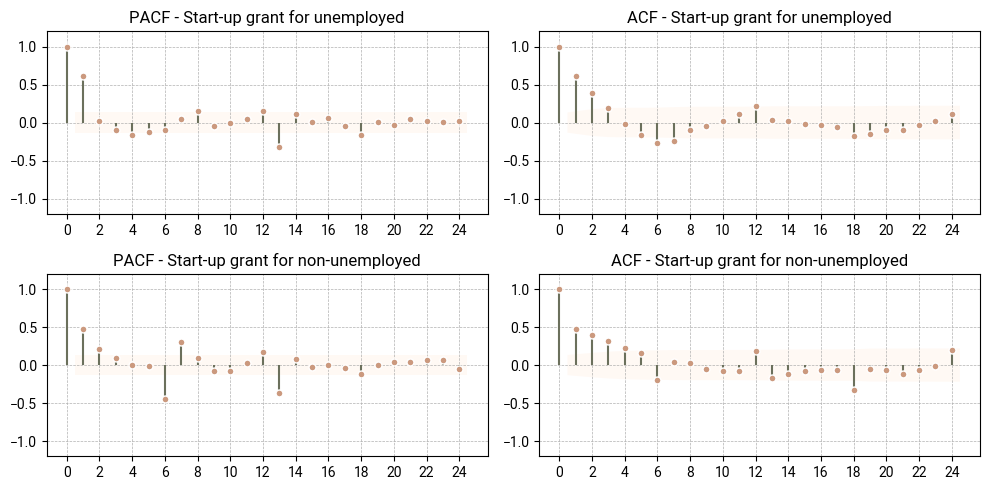

In [21]:
fig = plt.figure(figsize=FIGSIZE)

for i, col in enumerate(["grantUnemp", "grantEmp"]):
    ts = grant_data[col].diff().dropna()
    plot_pacf(
        x=ts,
        title="PACF - {n}".format(n=labels[col]),
        ax=fig.add_subplot(2, 2, 1 + i * 2),
        alpha=0.05,
        lags=LAGS,
    )

    plot_acf(
        x=ts,
        title="ACF - {n}".format(n=labels[col]),
        ax=fig.add_subplot(2, 2, 2 + i * 2),
        alpha=0.05,
        lags=LAGS,
    )


apply_TSplot_theme(fig.get_axes())

fig.tight_layout()
plt.show()

The PACF plot showed autocorrelation at lages 1,6, and 7. Therefore, these were included in the linear model. Furthermore, two constants are added for dates 2020-05-01 and 2021-12-01, where they have a value of 0 prior to the date, and 1 thereafter. 


These two dates were derived from the data itself, eventhough COVID restrictions were lifted two months later. 


# Investigating the COVID restriction impact:


In this analysis, we examine the impact of COVID restrictions on the number of start-up grant applications. The number of grants is divided by the applicant’s employment status (defined by Statistics Finland). 


There are three major dates defining the official start of the COVID restrictions: practical abolishment of the restrictions and official abolishment of the restrictions. The official start of the restrictions enforced closing down businesses, enacting safety measures in the workplace, and encouraging remote working in April 2020. The practical abolishment was set in August 2021, when the majority of the businesses became operational under workplace health and safety policies. The official ending was February 2022, when the government officially ended the COVID restrictions. 

## Implementation


We use a univariate time-series model to analyse the data and investigate the impact of the COVID restriction on the number of start-up applications. We chose the seasonal autoregressive integrated moving average (SARIMA) model. The configuration of the model is based on ACF and PACF observations and minimisation of the AIC and BIC of the model.


Policy impacts can be modelled in several ways. One method includes dates as a dummy variable, indicating that the date of interest has passed. 


We specify two restriction periods starting at the official announcement. One period ends with a practical abolishment, and the other ends with an official abolishment. 


We specified four models using combinations of durations. 




### Start-up grant for unemployed

We specify the orders of the SARIMA model for Start-up grant for unemployed series as:

 - ARIMA: 
    - AR: 1,4
 - Seasonal
    - MA: 1
    - interval: Monthly (12)

In [22]:
regressors = [
    "official - Duration",
    "practical - Duration",
    "start",
    "official end",
    "practical end",
    "ar.L1",
    "ar.L4",
    "ma.S.L12",
    "sigma2",
]



col = "grantUnemp"
model_df = grant_data.copy()
model_df.loc[:, "official - Duration"] = (
    (model_df.index >= "2020-04-01") & (model_df.index <= "2022-02-01")
).astype(int)
model_df.loc[:, "practical - Duration"] = (
    (model_df.index >= "2020-04-01") & (model_df.index <= "2021-07-01")
).astype(int)
model_df.loc[:, "start"] = (model_df.index >= "2020-04-01").astype(int)
model_df.loc[:, "practical end"] = (model_df.index >= "2021-07-01").astype(int)
model_df.loc[:, "official end"] = (model_df.index >= "2022-02-01").astype(int)

model_df[(col + " diff")] = model_df[col].diff()
model_df = model_df.dropna()

params = dict(
    endog=model_df[col + " diff"],
    order=([1, 4], 0, 0),
    seasonal_order=(0, 0, 1, 12),
)

models = dict(
    model_none=SARIMAX(**params).fit(disp=False),
    model_official_dur=SARIMAX(
        **params,
        exog=model_df[["official - Duration"]],
    ).fit(disp=False),
    model_practical_dur=SARIMAX(
        **params, exog=model_df[["practical - Duration"]]
    ).fit(disp=False),
    model_all_dur=SARIMAX(
        **params,
        exog=model_df[["official - Duration", "practical - Duration"]],
    ).fit(disp=False),
    model_practical_dum=SARIMAX(
        **params,
        exog=model_df[["start", "practical end"]],
    ).fit(disp=False),
    model_official_dum=SARIMAX(
        **params,
        exog=model_df[["start", "official end"]],
    ).fit(disp=False)
)

model_names = dict(
    zip(
        models.keys(),
        [
            "Base",
            "Offician Dur.",
            "practical Dur.",
            "Both Dur.",
            "Practical Dummy",
            "Official Dummy",
        ],
    )
)

summary_col(
    list(models.values()),
    model_names=list(model_names.values()),
    stars=True,
    float_format="%0.2f",
    info_dict={
        "BIC": lambda x: "{0:0.2f}".format(x.bic),
        "AIC": lambda x: "{0:0.2f}".format(x.aic),
        "Log-Likelihood": lambda x: "{0:0.3f}".format(x.llf),
    },
    regressor_order=(regressors)
)



,Base,Offician Dur.,practical Dur.,Both Dur.,Practical Dummy,Official Dummy
official - Duration,,30.63*,,-19.65,,
,,(15.93),,(36.94),,
practical - Duration,,,60.33***,78.20**,,
,,,(14.72),(39.19),,
start,,,,,65.98***,39.81***
,,,,,(14.54),(15.43)
official end,,,,,,-31.71
,,,,,,(27.63)
practical end,,,,,-63.50**,
,,,,,(24.76),


The results of the model show that practical duration increased the number of applications by unemployed applicants. Although the official duration has a slight significance, the significance disappears when both durations are included in the model. 


The following plots show the goodness-of-fit measurements. The models fit properly.


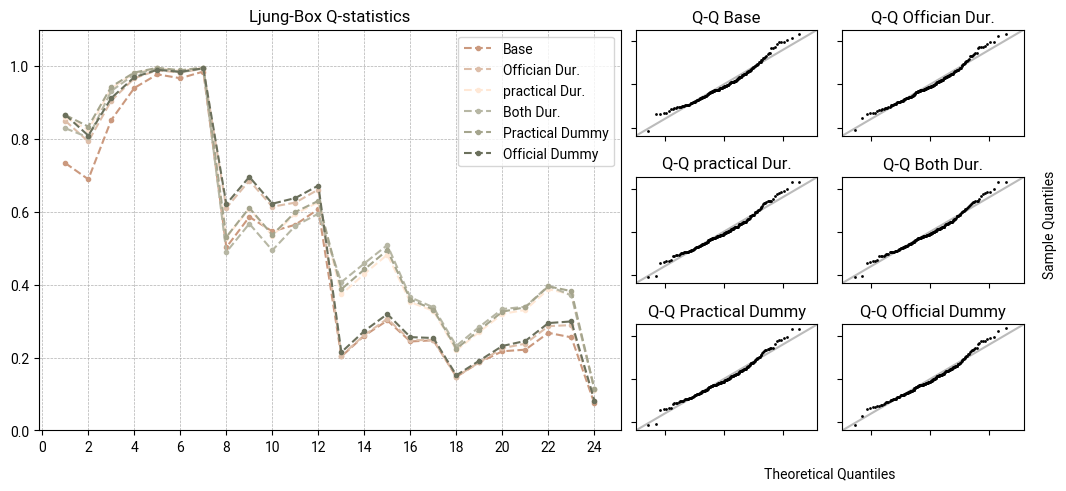

In [23]:
fig = plt.figure(layout='constrained', figsize=FIGSIZE)
subfigs = fig.subfigures(1, 2, width_ratios=[3,2])
axsLeft = subfigs[1].subplots(3, 2, sharex=True, sharey=True)
axsRight = subfigs[0].add_subplot(1,1,1)

keys = list(models.keys())
for i, ax in enumerate(axsLeft.flatten()):
    k = keys[i]
    residuals = models[k].resid.values
    # plot_Q_stats(residuals, ax=ax1, label = k)

    qqplot(residuals, ax= ax, line="45", fit=True)
    ax.lines[0].set_markersize(2)
    ax.lines[0].set_markerfacecolor("black")
    ax.lines[0].set_markeredgecolor("none")
    ax.lines[0].set_zorder(2)
    ax.lines[1].set_zorder(1)
    ax.lines[1].set_color("#BBBBBB")
    ax.set_title("Q-Q {name}".format(name=model_names[k]))
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    
    
subfigs[1].text(0.5,0, "Theoretical Quantiles", ha="center", va="center")
subfigs[1].text(1.05,0.5, "Sample Quantiles", ha="center", va="center", rotation=90)


for i, k in enumerate(models.keys()):
    residuals = models[k].resid.values
    plot_Q_stats(residuals, ax=axsRight, label=model_names[k])


for i, c in enumerate(COLOR_PALLET_GRADIENT):
    axsRight.lines[i].set_color(c)
    axsRight.lines[i].set_markersize(3)

axsRight.set_title("Ljung-Box Q-statistics")
axsRight.legend()

plt.tight_layout()
plt.show()

### Start-up grant for unemployed

We specify the orders of the SARIMA model for Start-up grant for unemployed series as:

 - ARIMA: 
    - AR: 1,6,7,13
 - Seasonal
    - MA: 1
    - interval: Monthly (12)

In [24]:
regressors = [
    "official - Duration",
    "practical - Duration",
    "start",
    "official end",
    "practical end",
    "ar.L1",
    "ar.L4",
    "ma.S.L12",
    "sigma2",
]

col = "grantEmp"
model_df = grant_data.copy()
model_df.loc[:, "official - Duration"] = (
    (model_df.index >= "2020-04-01") & (model_df.index <= "2022-02-01")
).astype(int)
model_df.loc[:, "practical - Duration"] = (
    (model_df.index >= "2020-04-01") & (model_df.index <= "2021-07-01")
).astype(int)
model_df.loc[:, "start"] = (model_df.index >= "2020-04-01").astype(int)
model_df.loc[:, "practical end"] = (model_df.index >= "2021-07-01").astype(int)
model_df.loc[:, "official end"] = (model_df.index >= "2022-02-01").astype(int)

model_df[(col + " diff")] = model_df[col].diff()
model_df = model_df.dropna()

params = dict(
    endog=model_df[col + " diff"],
    order=([1, 6,7,13], 0, 0),
    seasonal_order=(0, 0, 1, 12)
)

models = dict(
    model_none=SARIMAX(**params).fit(disp=False),
    model_official_dur=SARIMAX(
        **params,
        exog=model_df[["official - Duration"]],
    ).fit(disp=False),
    model_practical_dur=SARIMAX(
        **params, exog=model_df[["practical - Duration"]]
    ).fit(disp=False),
    model_all_dur=SARIMAX(
        **params,
        exog=model_df[["official - Duration", "practical - Duration"]],
    ).fit(disp=False),
    model_practical_dum=SARIMAX(
        **params,
        exog=model_df[["start", "practical end"]],
    ).fit(disp=False),
    model_official_dum=SARIMAX(
        **params,
        exog=model_df[["start", "official end"]],
    ).fit(disp=False)
)

model_names = dict(
    zip(
        models.keys(),
        [
            "Base",
            "Offician Dur.",
            "practical Dur.",
            "Both Dur.",
            "Practical Dummy",
            "Official Dummy",
        ],
    )
)

summary_col(
    list(models.values()),
    model_names=list(model_names.values()),
    stars=True,
    float_format="%0.2f",
    info_dict={
        "BIC": lambda x: "{0:0.2f}".format(x.bic),
        "AIC": lambda x: "{0:0.2f}".format(x.aic),
        "Log-Likelihood": lambda x: "{0:0.3f}".format(x.llf),
    },
    regressor_order=(regressors)
)



,Base,Offician Dur.,practical Dur.,Both Dur.,Practical Dummy,Official Dummy
official - Duration,,62.88***,,15.38,,
,,(15.39),,(25.63),,
practical - Duration,,,71.95***,60.00*,,
,,,(18.62),(30.76),,
start,,,,,79.19***,67.67***
,,,,,(17.82),(15.11)
official end,,,,,,-58.73**
,,,,,,(25.50)
practical end,,,,,-63.49***,
,,,,,(23.42),


The results for employed applicants also indicate significance for practical duration, while the significance of the official end is also significant. Although the joint model eliminates significance, the dummy variable specification maintains significance.


Following plots are Goodness-of-fit measurements. Models has fit properly.




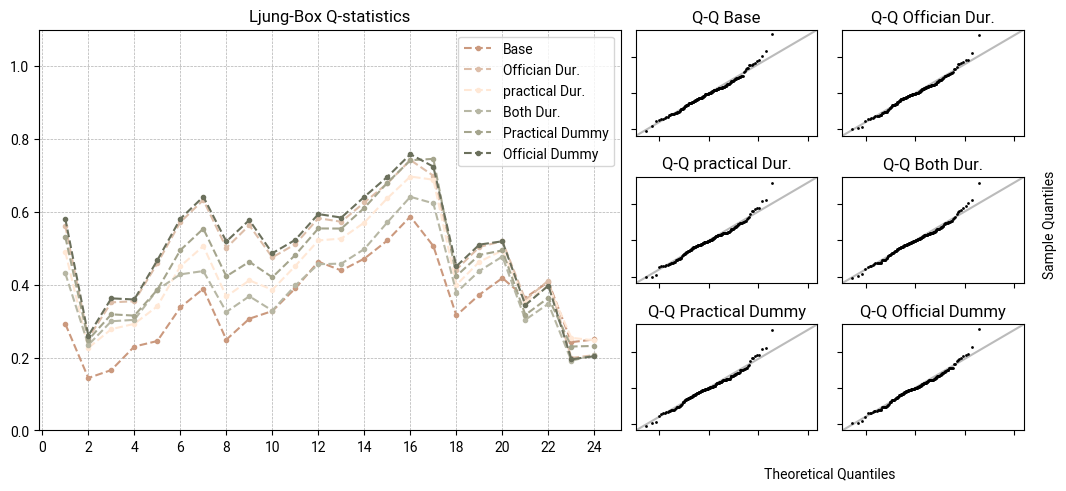

In [25]:
fig = plt.figure(layout='constrained', figsize=FIGSIZE)
subfigs = fig.subfigures(1, 2, width_ratios=[3,2])
axsLeft = subfigs[1].subplots(3, 2, sharex=True, sharey=True)
axsRight = subfigs[0].add_subplot(1,1,1)

keys = list(models.keys())
for i, ax in enumerate(axsLeft.flatten()):
    k = keys[i]
    residuals = models[k].resid.values
    # plot_Q_stats(residuals, ax=ax1, label = k)

    qqplot(residuals, ax= ax, line="45", fit=True)
    ax.lines[0].set_markersize(2)
    ax.lines[0].set_markerfacecolor("black")
    ax.lines[0].set_markeredgecolor("none")
    ax.lines[0].set_zorder(2)
    ax.lines[1].set_zorder(1)
    ax.lines[1].set_color("#BBBBBB")
    ax.set_title("Q-Q {name}".format(name=model_names[k]))
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    
    
subfigs[1].text(0.5,0, "Theoretical Quantiles", ha="center", va="center")
subfigs[1].text(1.05,0.5, "Sample Quantiles", ha="center", va="center", rotation=90)


for i, k in enumerate(models.keys()):
    residuals = models[k].resid.values
    plot_Q_stats(residuals, ax=axsRight, label=model_names[k])


for i, c in enumerate(COLOR_PALLET_GRADIENT):
    axsRight.lines[i].set_color(c)
    axsRight.lines[i].set_markersize(3)

axsRight.set_title("Ljung-Box Q-statistics")
axsRight.legend()

plt.tight_layout()
plt.show()

# Conclusion

Based on the evidence illustrated in this notebook so far, we can conclude that there was a significant increase in start-up grant applications during the COVID restriction period for both unemployed and non-unemployed individuals. This increase appears to stop after the COVID restriction period. However, the non-unemployed seem to stop inceasing at the practical date, and non-unemployed individuals stop increasing their application count at the official ending date. The levels of application count remained at increased levels and did not decrease to an itsprevious state.